In [19]:
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 14})
import scienceplots

plt.style.use('science')

In [20]:
ROLL_SURFACE_TEMPERATURE = 50 + 273.15
DISK_ELEMENT_COUNT = 30

In [21]:
root_dir = Path.cwd()
result_dir = root_dir / "res"

In [22]:
from rolling_sequence import finishing_pass_design_1, finishing_pass_design_2, finishing_pass_design_3
from utilities import *

In [23]:
pass_design_1 = finishing_pass_design_1(ROLL_SURFACE_TEMPERATURE, DISK_ELEMENT_COUNT)
pass_design_2 = finishing_pass_design_2(ROLL_SURFACE_TEMPERATURE, DISK_ELEMENT_COUNT)
pass_design_3 = finishing_pass_design_3(ROLL_SURFACE_TEMPERATURE, DISK_ELEMENT_COUNT)

In [24]:
def calculate_wear_areas():
    sequences = [
        {"label": "RPD1", "sequence": pass_design_1},
        {"label": "RPD2", "sequence": pass_design_2},
        {"label": "RPD3", "sequence": pass_design_3}
    ]

    wear_areas = []

    for entry in sequences:
        groove_label = entry["label"]
        sequence = entry["sequence"]
        roll_passes = sequence.roll_passes
        measurements = extract_wear_contours_from_measurement(groove_label)

        for measurement_id, labels, tonnages, measured_wear_contours in measurements:
            for roll_pass in roll_passes:
                for label, tonnage, measured_wear_contour in zip(labels, tonnages, measured_wear_contours):
                    if roll_pass.label == label:
                        wear_area = calculate_area_between_contours(roll_pass.roll.contour_line, measured_wear_contour )#, debug=True, debug_info={"label": label, "measurement_id": measurement_id})
                        normed_wear_area = wear_area / roll_pass.roll.groove.cross_section.area
                        wear_areas.append({
                            "groove": groove_label,
                            "measurement_id": measurement_id,
                            "label": label,
                            "tonnage": tonnage,
                            "wear_area": wear_area,
                            "normed_wear_area": normed_wear_area
                        })

    return wear_areas

In [25]:
wear_areas = calculate_wear_areas()

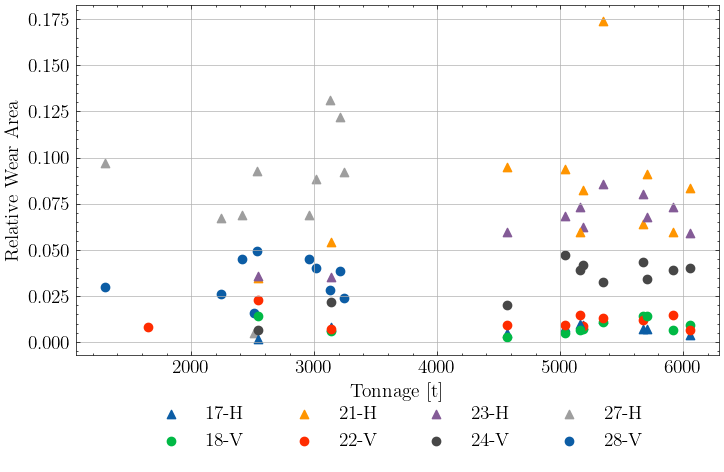

In [30]:
label_colors = {}
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i, label in enumerate(sorted(set(d['label'] for d in wear_areas))):
    label_colors[label] = color_cycle[i % len(color_cycle)]

fig: plt.Figure = plt.figure(figsize=(8.3, 6))
ax: plt.Axes
axl: plt.Axes
ax, axl = fig.subplots(nrows=2, height_ratios=[1, 0.2])
ax.set_ylabel('Relative Wear Area')
ax.grid()
ax.set_xlabel('Tonnage [t]')
for wear_dicts in wear_areas:
    if wear_dicts['label'] in ["17-H", "21-H", "23-H", "27-H"]:
         marker = '^'
    else:
        marker = 'o'
    ax.scatter(wear_dicts['tonnage'], wear_dicts['normed_wear_area'], color=label_colors[wear_dicts['label']],
               label=wear_dicts['label'], marker=marker)

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))

axl.axis("off")
axl.legend(by_label.values(), by_label.keys(), ncols=4, loc="lower center")

fig.savefig(result_dir / "wear_area_measurements.pdf",dpi=300, bbox_inches="tight")

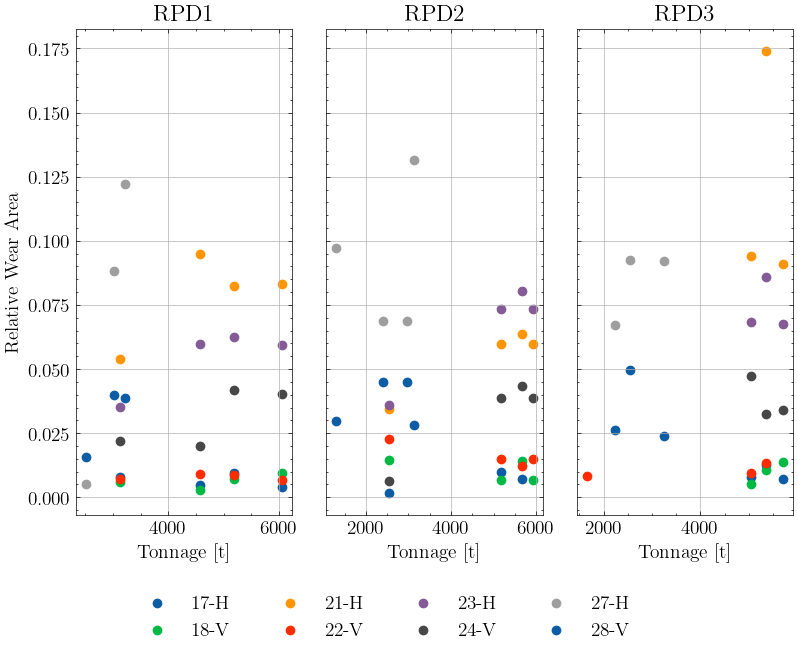

In [32]:
label_colors = {}
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i, label in enumerate(sorted(set(d['label'] for d in wear_areas))):
    label_colors[label] = color_cycle[i % len(color_cycle)]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8.3, 6), sharey=True)
ax1.set_ylabel('Relative Wear Area')

for wear_dicts in wear_areas:
    if wear_dicts['groove'] == 'RPD1':
        ax1.scatter(wear_dicts['tonnage'], wear_dicts['normed_wear_area'], color=label_colors[wear_dicts['label']],
                    label=wear_dicts['label'])

ax1.set_title('RPD1')
ax1.set_xlabel('Tonnage [t]')
ax1.grid()

for wear_dicts in wear_areas:
    if wear_dicts['groove'] == 'RPD2':
        ax2.scatter(wear_dicts['tonnage'], wear_dicts['normed_wear_area'], color=label_colors[wear_dicts['label']],
                    label=wear_dicts['label'])

ax2.set_title('RPD2')
ax2.set_xlabel('Tonnage [t]')
ax2.grid()

for wear_dicts in wear_areas:
    if wear_dicts['groove'] == 'RPD3':
        ax3.scatter(wear_dicts['tonnage'], wear_dicts['normed_wear_area'], color=label_colors[wear_dicts['label']],
                    label=wear_dicts['label'])

ax3.set_title('RPD3')
ax3.set_xlabel('Tonnage [t]')
ax3.grid()

handles2, labels2 = ax1.get_legend_handles_labels()
by_label2 = dict(zip(labels2, handles2))
fig.legend(by_label2.values(), by_label2.keys(), bbox_to_anchor=(0.8, 0.01), ncol=4)

plt.tight_layout()
fig.savefig(result_dir / "wear_area_measurements_per_rpd.pdf",dpi=300, bbox_inches="tight")

In [33]:
values_rpd1 = []
values_rpd2 = []
values_rpd3 = []
for wear_dicts in wear_areas:
    if wear_dicts['groove'] == 'RPD1':
        values_rpd1.append(wear_dicts)
    if wear_dicts['groove'] == 'RPD2':
        values_rpd2.append(wear_dicts)
    if wear_dicts['groove'] == 'RPD3':
        values_rpd3.append(wear_dicts)
values = [values_rpd1, values_rpd2, values_rpd3]

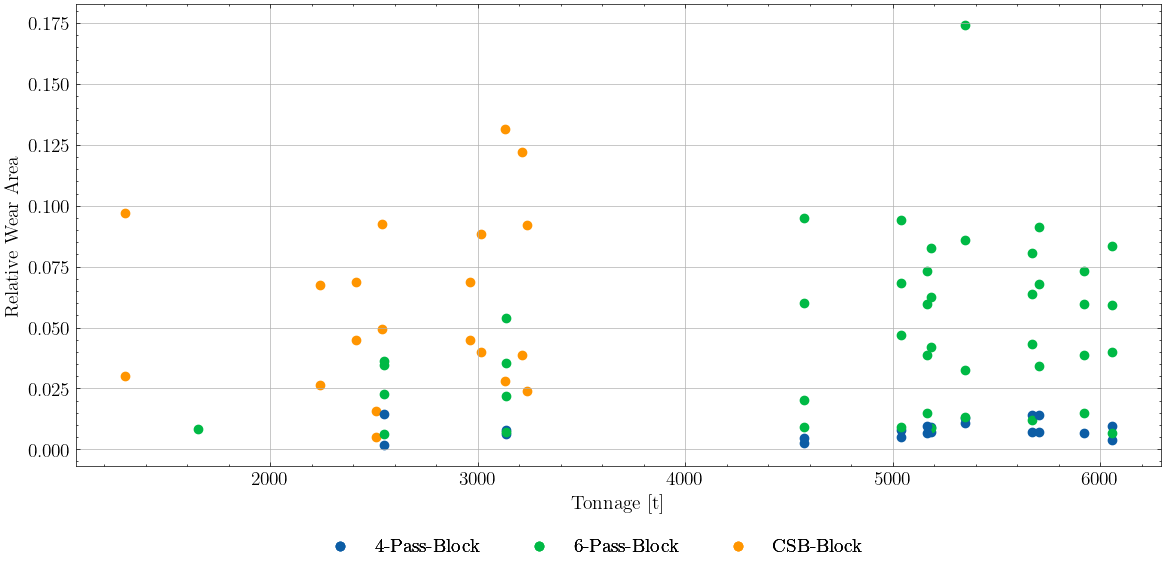

In [34]:
label_colors = {}
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i, label in enumerate(sorted(set(d['label'] for d in values_rpd1))):
    label_colors[label] = color_cycle[i % len(color_cycle)]

fig, ax = plt.subplots(figsize=(14, 6))
for value in values:
    for wear_dicts in value:
        if wear_dicts['label'] in ["17-H", "18-V"]:
            ax.scatter(wear_dicts['tonnage'], wear_dicts['normed_wear_area'], color='C0',  label="4-Pass-Block")
        elif wear_dicts['label'] in ["21-H", "22-V", "23-H", "24-V"]:
            ax.scatter(wear_dicts['tonnage'], wear_dicts['normed_wear_area'], color='C1',  label="6-Pass-Block")

        elif wear_dicts['label'] in ["27-H", "28-V"]:
            ax.scatter(wear_dicts['tonnage'], wear_dicts['normed_wear_area'], color='C2', label="CSB-Block")

    ax.set_xlabel('Tonnage [t]')
    ax.set_ylabel('Relative Wear Area')
    ax.grid()
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.7, 0.02), ncol=3)

fig.savefig(result_dir / "wear_area_measurements_per_block.pdf",dpi=300, bbox_inches="tight")